LSTM 기반의 삼성전자 주가 예측 예제
 - yahoo finance에서 데이터 다운로드 후 3일(3MA), 5일(5MA) 가격이동평균선 추가

In [5]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

데이터 불러오기

In [6]:
# https://finance.yahoo.com/quote/005930.KS/

!pip install pandas_datareader
!pip install yfinance

In [7]:
import yfinance as yf
from pandas_datareader import data as pdr

# 'yfinance' 모듈의 데이터 가져오기 기능을 Pandas DataReader와 호환되도록 설정
yf.pdr_override()

# 22/01/01 ~ 23/01/01 삼성전자 주식 데이터를 가져와서 DataFrame으로 저장
raw_df=pdr.get_data_yahoo("005930.KS", start="2022-01-01", end="2023-01-01")
raw_df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-01-04,78800.0,79200.0,78300.0,78700.0,75235.234375,12427416
2022-01-05,78800.0,79000.0,76400.0,77400.0,73992.453125,25470640
2022-01-06,76700.0,77600.0,76600.0,76900.0,73514.468750,12931954
2022-01-07,78100.0,78400.0,77400.0,78300.0,74852.843750,15163757
2022-01-10,78100.0,78100.0,77100.0,78000.0,74566.031250,9947422


In [8]:
# 고가(high)와 저가(low)를 이용하여 중간값(mid)을 계산하고, 이를 데이터프레임에 추가

high_prices = raw_df['High'].values # 'High'열에 해당하는 고가 데이터를 추출하여 넘파이 배열로 변환
low_prices = raw_df['Low'].values
mid_prices = (high_prices+low_prices)/2
mid_prices

raw_df['Mid'] = mid_prices
raw_df

,Open,High,Low,Close,Adj Close,Volume,Mid
Date,,,,,,,
2022-01-04,78800.0,79200.0,78300.0,78700.0,75235.234375,12427416,78750.0
2022-01-05,78800.0,79000.0,76400.0,77400.0,73992.453125,25470640,77700.0
2022-01-06,76700.0,77600.0,76600.0,76900.0,73514.468750,12931954,77100.0
2022-01-07,78100.0,78400.0,77400.0,78300.0,74852.843750,15163757,77900.0
2022-01-10,78100.0,78100.0,77100.0,78000.0,74566.031250,9947422,77600.0
...,...,...,...,...,...,...,...
2022-12-23,58200.0,58400.0,57700.0,58100.0,56556.574219,9829407,58050.0
2022-12-26,58000.0,58100.0,57700.0,57900.0,56361.878906,6756411,57900.0
2022-12-27,58000.0,58400.0,57900.0,58100.0,56556.574219,10667027,58150.0


In [9]:
# 수정 종가 데이터를 이용하여 5일 이동평균을 계산하고, 이를 원본 데이터프레임에 추가

ma5 = raw_df['Adj Close'].rolling(window=5).mean()
raw_df['MA5'] = ma5
raw_df = raw_df.fillna(0) # NaN값(결측값)을 0으로 채움
raw_df

,Open,High,Low,Close,Adj Close,Volume,Mid,MA5
Date,,,,,,,,
2022-01-04,78800.0,79200.0,78300.0,78700.0,75235.234375,12427416,78750.0,0.000000
2022-01-05,78800.0,79000.0,76400.0,77400.0,73992.453125,25470640,77700.0,0.000000
2022-01-06,76700.0,77600.0,76600.0,76900.0,73514.468750,12931954,77100.0,0.000000
2022-01-07,78100.0,78400.0,77400.0,78300.0,74852.843750,15163757,77900.0,0.000000
2022-01-10,78100.0,78100.0,77100.0,78000.0,74566.031250,9947422,77600.0,74432.206250
...,...,...,...,...,...,...,...,...
2022-12-23,58200.0,58400.0,57700.0,58100.0,56556.574219,9829407,58050.0,57101.694531
2022-12-26,58000.0,58100.0,57700.0,57900.0,56361.878906,6756411,57900.0,56790.194531
2022-12-27,58000.0,58400.0,57900.0,58100.0,56556.574219,10667027,58150.0,56692.851562


In [10]:
# 수정 종가 데이터를 이용하여 3일 이동평균을 계산하고, 이를 원본 데이터프레임에 추가
# rolling 메소드를 사용하여 이동평균 계산

ma3 = raw_df['Adj Close'].rolling(window=3).mean() # window 매개변수에 이동평균을 계산할 기간 지정
raw_df['MA3'] = ma3
raw_df = raw_df.fillna(0)

,Open,High,Low,Close,Adj Close,Volume,Mid,MA5,MA3
Date,,,,,,,,,
2022-01-04,78800.0,79200.0,78300.0,78700.0,75235.234375,12427416,78750.0,0.000000,0.000000
2022-01-05,78800.0,79000.0,76400.0,77400.0,73992.453125,25470640,77700.0,0.000000,0.000000
2022-01-06,76700.0,77600.0,76600.0,76900.0,73514.468750,12931954,77100.0,0.000000,74247.385417
2022-01-07,78100.0,78400.0,77400.0,78300.0,74852.843750,15163757,77900.0,0.000000,74119.921875
2022-01-10,78100.0,78100.0,77100.0,78000.0,74566.031250,9947422,77600.0,74432.206250,74311.114583
...,...,...,...,...,...,...,...,...,...
2022-12-23,58200.0,58400.0,57700.0,58100.0,56556.574219,9829407,58050.0,57101.694531,56848.601562
2022-12-26,58000.0,58100.0,57700.0,57900.0,56361.878906,6756411,57900.0,56790.194531,56816.152344
2022-12-27,58000.0,58400.0,57900.0,58100.0,56556.574219,10667027,58150.0,56692.851562,56491.675781


In [11]:
raw_df['Adj Close']

Date
2022-01-04    75235.234375
2022-01-05    73992.453125
2022-01-06    73514.468750
2022-01-07    74852.843750
2022-01-10    74566.031250
                  ...     
2022-12-23    56556.574219
2022-12-26    56361.878906
2022-12-27    56556.574219
2022-12-28    55440.894531
2022-12-29    54167.519531
Name: Adj Close, Length: 244, dtype: float64

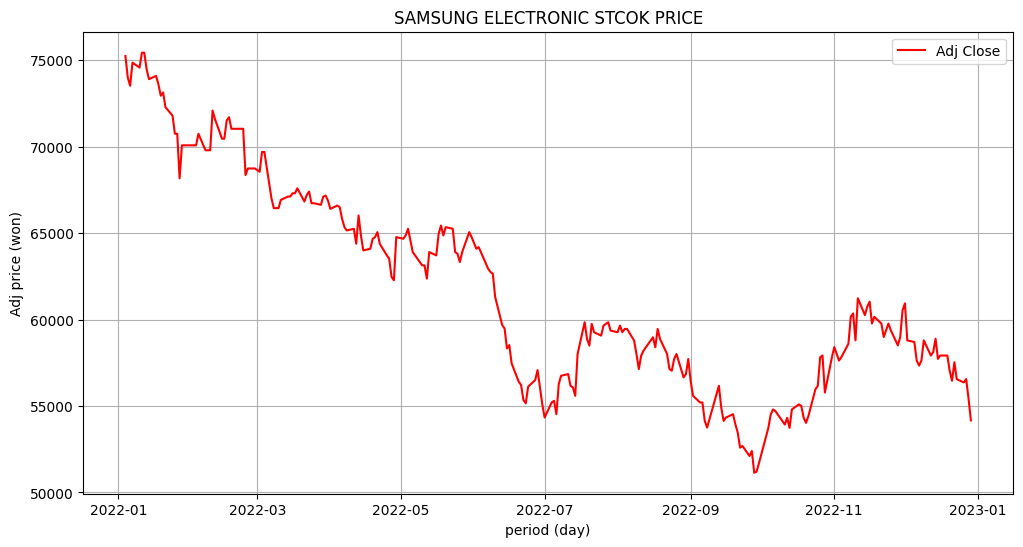

In [12]:
# 삼성전자 주식의 수정 종가 데이터를 시간에 따라 그래프로 시각화

plt.figure(figsize=(12, 6))
plt.title('SAMSUNG ELECTRONIC STCOK PRICE')
plt.ylabel('Adj price (won)')
plt.xlabel('period (day)')
plt.grid()
plt.plot(raw_df['Adj Close'], label='Adj Close', color='r')
plt.legend(loc='best')
plt.show()

데이터 전처리 (Missing Data 처리, 정규화 등)

In [13]:
# 통계정보 확인
raw_df.describe()

,Open,High,Low,Close,Adj Close,Volume,Mid,MA5,MA3
count,244.000000,244.000000,244.000000,244.000000,244.000000,2.440000e+02,244.000000,244.000000,244.000000
mean,63924.590164,64400.819672,63413.934426,63867.213115,61572.804047,1.389583e+07,63907.377049,60509.469730,61042.423097
std,6666.108760,6548.106199,6620.175120,6587.642036,5993.763909,5.707975e+06,6579.917608,9743.659760,8098.546246
min,52300.000000,53600.000000,51800.000000,52600.000000,51143.300781,0.000000e+00,52700.000000,0.000000,0.000000
25%,58700.000000,59200.000000,58200.000000,58800.000000,56847.375000,1.064984e+07,58787.500000,56775.565820,56968.528320
50%,61500.000000,61950.000000,61000.000000,61600.000000,59661.986328,1.357296e+07,61450.000000,59486.713281,59483.406901
75%,68800.000000,69075.000000,68525.000000,68800.000000,66111.046875,1.683705e+07,68725.000000,65323.095898,65550.512044
max,79500.000000,79600.000000,78600.000000,78900.000000,75426.414062,3.794336e+07,79100.000000,74948.428125,75139.619792


In [14]:
# Missing Data 확인
raw_df.isnull().sum() # 0으로 채워져있기 때문에 결측치 없음

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Mid          0
MA5          0
MA3          0
dtype: int64

In [15]:
# 최소값이 0인 열의 열 이름과 열 이름의 데이터 형식을 출력

for col in raw_df.columns: 

    if raw_df[col].min() == 0:
        col_name = col
        print(col_name, type(col_name))

Volume <class 'str'>
MA5 <class 'str'>
MA3 <class 'str'>


In [16]:
raw_df.loc[raw_df['Volume']==0]

,Open,High,Low,Close,Adj Close,Volume,Mid,MA5,MA3
Date,,,,,,,,,
2022-01-26,74000.0,74000.0,74000.0,74000.0,70742.156250,0,74000.0,71736.357813,71092.674479
2022-02-08,73000.0,73000.0,73000.0,73000.0,69786.164062,0,73000.0,70092.081250,70104.828125
2022-02-09,73000.0,73000.0,73000.0,73000.0,69786.164062,0,73000.0,70034.721875,69786.164062
2022-02-21,74300.0,74300.0,74300.0,74300.0,71028.937500,0,74300.0,71143.651563,71251.994792
2022-02-22,74300.0,74300.0,74300.0,74300.0,71028.937500,0,74300.0,71258.368750,71028.937500
2022-02-23,74300.0,74300.0,74300.0,74300.0,71028.937500,0,74300.0,71162.771875,71028.937500
2022-02-28,71900.0,71900.0,71900.0,71900.0,68734.601562,0,71900.0,69575.854688,68607.132812
2022-03-04,72900.0,72900.0,72900.0,72900.0,69690.578125,0,72900.0,69078.751562,69308.184896
2022-03-10,69500.0,69500.0,69500.0,69500.0,66440.257812,0,69500.0,67855.103125,66631.453125


In [17]:
raw_df.shape

(244, 9)

In [18]:
for col in raw_df.columns:

    missing_rows = raw_df.loc[raw_df[col]==0].shape[0] # 현재 순회 중인 열에 대해 해당 열의 값이 0인 행들을 선택
    print(col + ': ' + str(missing_rows))

Open: 0
High: 0
Low: 0
Close: 0
Adj Close: 0
Volume: 11
Mid: 0
MA5: 4
MA3: 2


In [19]:
# 0을 NaN(결측치)으로 바꾼 후, 각 열에 대해 0이 몇 개 있는지 확인

raw_df['Volume'] = raw_df['Volume'].replace(0, np.nan) # 'Volume'열에 있는 0 -> 결측치로 처리

for col in raw_df.columns:

    missing_rows = raw_df.loc[raw_df[col]==0].shape[0]
    print(col + ': ' + str(missing_rows))

Open: 0
High: 0
Low: 0
Close: 0
Adj Close: 0
Volume: 0
Mid: 0
MA5: 4
MA3: 2


In [20]:
# Missing Data 확인
raw_df.isnull().sum()

Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume       11
Mid           0
MA5           0
MA3           0
dtype: int64

In [21]:
raw_df.isnull().any()

Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume        True
Mid          False
MA5          False
MA3          False
dtype: bool

In [22]:
raw_df.loc[raw_df['Open'].isna()]

,Open,High,Low,Close,Adj Close,Volume,Mid,MA5,MA3
Date,,,,,,,,,


In [23]:
# Missing Data 처리

raw_df = raw_df.dropna()

raw_df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Mid          0
MA5          0
MA3          0
dtype: int64

In [24]:
# 정규화 (Date 제외한 모든 수치부분 정규화)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scale_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close',
              'MA3', 'MA5', 'Volume']

scaled_df = scaler.fit_transform(raw_df[scale_cols])

scaled_df = pd.DataFrame(scaled_df, columns=scale_cols)

print(scaled_df)

         Open      High       Low     Close  Adj Close       MA3       MA5  \
0    0.974265  0.984615  0.988806  0.992395   0.992127  0.000000  0.000000   
1    0.974265  0.976923  0.917910  0.942966   0.940948  0.000000  0.000000   
2    0.897059  0.923077  0.925373  0.923954   0.921264  0.988126  0.000000   
3    0.948529  0.953846  0.955224  0.977186   0.976380  0.986429  0.000000   
4    0.948529  0.942308  0.944030  0.965779   0.964569  0.988974  0.993112   
..        ...       ...       ...       ...        ...       ...       ...   
228  0.216912  0.184615  0.220149  0.209125   0.222923  0.756573  0.761880   
229  0.209559  0.173077  0.220149  0.201521   0.214906  0.756141  0.757724   
230  0.209559  0.184615  0.227612  0.209125   0.222923  0.751823  0.756425   
231  0.194853  0.153846  0.171642  0.152091   0.176979  0.746873  0.753707   
232  0.136029  0.100000  0.130597  0.102662   0.124540  0.737139  0.744735   

       Volume  
0    0.206975  
1    0.612353  
2    0.222656  

In [25]:
# 입력 파라미터 feature, label => numpy type

def make_sequene_dataset(feature, label, window_size):

    feature_list = []      # 생성될 feature list
    label_list = []        # 생성될 label list

    for i in range(len(feature)-window_size):

        feature_list.append(feature[i:i+window_size])
        label_list.append(label[i+window_size])

    return np.array(feature_list), np.array(label_list)

In [26]:
# feature_df, label_df 생성

feature_cols = [ 'MA3', 'MA5', 'Adj Close' ]
label_cols = [ 'Adj Close' ]

feature_df = pd.DataFrame(scaled_df, columns=feature_cols)
label_df = pd.DataFrame(scaled_df, columns=label_cols)

In [27]:
# DataFrame => Numpy 변환

feature_np = feature_df.to_numpy()
label_np = label_df.to_numpy()

print(feature_np.shape, label_np.shape)

(233, 3) (233, 1)


시계열 데이터 생성 (make_sequence_dataset)

In [28]:
window_size = 40

X, Y = make_sequene_dataset(feature_np, label_np, window_size)

print(X.shape, Y.shape)

(193, 40, 3) (193, 1)


학습데이터, 테스트데이터 생성

In [29]:
# train, test 분리

split = int(len(X)*0.8)
# split = -200

x_train = X[0:split]
y_train = Y[0:split]

x_test = X[split:]
y_test = Y[split:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(154, 40, 3) (154, 1)
(39, 40, 3) (39, 1)


모델 구축 및 컴파일

In [30]:
model = Sequential()

In [31]:
model.add(LSTM(128, activation='tanh', input_shape=x_train[0].shape))

In [32]:
model.add(Dense(1, activation='tanh'))

In [33]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               67584     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 67713 (264.50 KB)
Trainable params: 67713 (264.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


모델 학습 (EarlyStopping 적용)

In [34]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          epochs=100, batch_size=16,
          callbacks=[early_stop])

Epoch 1/100


10/10 [==============================] - 2s 63ms/step - loss: 0.0380 - mae: 0.1560 - val_loss: 0.0057 - val_mae: 0.0617
Epoch 2/100
10/10 [==============================] - 0s 15ms/step - loss: 0.0195 - mae: 0.1152 - val_loss: 0.0069 - val_mae: 0.0703
Epoch 3/100
10/10 [==============================] - 0s 15ms/step - loss: 0.0095 - mae: 0.0841 - val_loss: 0.0038 - val_mae: 0.0473
Epoch 4/100
10/10 [==============================] - 0s 15ms/step - loss: 0.0056 - mae: 0.0605 - val_loss: 0.0053 - val_mae: 0.0537
Epoch 5/100
10/10 [==============================] - 0s 16ms/step - loss: 0.0047 - mae: 0.0548 - val_loss: 0.0032 - val_mae: 0.0458
Epoch 6/100
10/10 [==============================] - 0s 16ms/step - loss: 0.0042 - mae: 0.0524 - val_loss: 0.0031 - val_mae: 0.0462
Epoch 7/100
10/10 [==============================] - 0s 15ms/step - loss: 0.0039 - mae: 0.0507 - val_loss: 0.0028 - val_mae: 0.0423
Epoch 8/100
10/10 [==============================] - 0s 16ms/step - loss: 

예측을 통한 정답과의 비교
(오차 계산 MAPE 사용, 평균 절대값 백분율 오차)

2/2 [==============================] - 0s 5ms/step


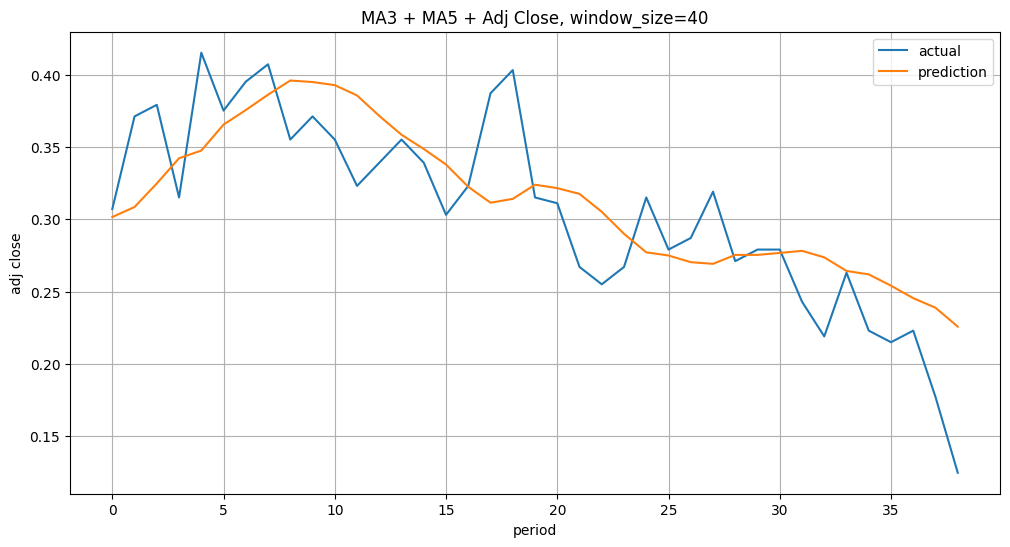

In [35]:
pred = model.predict(x_test)

plt.figure(figsize=(12, 6))
plt.title('MA3 + MA5 + Adj Close, window_size=40')
plt.ylabel('adj close')
plt.xlabel('period')
plt.plot(y_test, label='actual')
plt.plot(pred, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()

In [36]:
# 평균 절대값 백분율 오차(MAPE: Mean Absolute Percentage Error) 계산

print(np.sum(abs(y_test-pred)/y_test) / len(x_test))

0.1228930377212264
